In [229]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  5 19:08:23 2024

@author: MDL Workstation
"""

# conda install cudatoolkit
# conda install numba

# Transformer model reference https://peterbloem.nl/blog/transformers

# Transformer model reference was taken from https://www.tensorflow.org/text/tutorials/transformer
# import numba
# from numba import jit, cuda

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# pip install scikit-learn

import joblib
import pandas as pd
import glob
import numpy as np
import os
import scipy.stats as stats
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate
from sklearn import preprocessing
from scipy.stats import norm
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle
print(tf.__version__)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
import torch
import random

import csv
import os,random

# The code is run on a CPU

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda

import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now


random.seed(1337)
np.random.seed(1337) # For reproducibility
torch.manual_seed(1337)


timesteps = 320  # number of timesteps
nr = 80   # number of repetitions
n_dim = 132  # dimension of the data sequences


exercise = 'E1'

split_data_path = '/content/' + exercise + '_split_4.pkl'
split_data = joblib.load(split_data_path)


X_train = split_data['train']['data']
y_train = split_data['train']['labels']

X_test = split_data['test']['data']
y_test = split_data['test']['labels']

2.15.0


In [230]:
import numpy as np

# Replace NaN values with mean in training data
nan_mask_train_X = np.isnan(X_train)
mean_values_train_X = np.nanmean(X_train)
X_train[nan_mask_train_X] = mean_values_train_X

nan_mask_train_y = np.isnan(y_train)
mean_values_train_y = np.nanmean(y_train)
y_train[nan_mask_train_y] = mean_values_train_y

# Replace NaN values with mean in testing data
nan_mask_test_X = np.isnan(X_test)
mean_values_test_X = np.nanmean(X_test)
X_test[nan_mask_test_X] = mean_values_test_X

nan_mask_test_y = np.isnan(y_test)
mean_values_test_y = np.nanmean(y_test)
y_test[nan_mask_test_y] = mean_values_test_y



print("The X_train size is ", X_train.shape)
print("The y_train size is ", y_train.shape)
print("The X_test size is ", X_test.shape)
print("The y_test size is ", y_test.shape)



def makeDataDivisibleBy8(myData, sizeRequired):

    newData = []

    for file in myData:
        print("The length of the file is ", file.shape[0])
        rows_to_append = sizeRequired - file.shape[0]
        zero_rows = np.zeros((rows_to_append, file.shape[1]))
        file = np.vstack([file, zero_rows])
        newData.append(file)

    print("The size after zero stacking is ", newData[0].shape)

    return np.array(newData)


train_x = makeDataDivisibleBy8(X_train, timesteps)
valid_x = makeDataDivisibleBy8(X_test, timesteps)


train_y = y_train
valid_y = y_test

The X_train size is  (120, 180, 132)
The y_train size is  (120,)
The X_test size is  (40, 180, 132)
The y_test size is  (40,)
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The length of the file is  180
The le

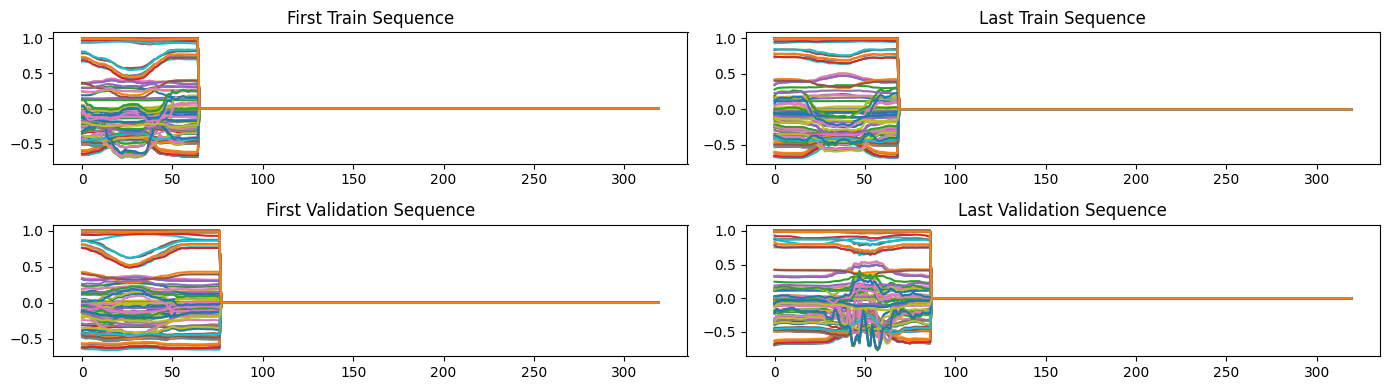

In [231]:
# Plot the first and last sequence in the training and validation sets
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()


# Reduce the data length by a factor of 2, 4, and 8
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
valid_x_2 = np.zeros(train_x_2.shape)
train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
valid_x_4 = np.zeros(train_x_4.shape)
train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
valid_x_8 = np.zeros(train_x_8.shape)
train_x_2 = train_x[:,::2,:]
valid_x_2 = valid_x[:,::2,:]
train_x_4 = train_x[:,::4,:]
valid_x_4 = valid_x[:,::4,:]
train_x_8 = train_x[:,::8,:]
valid_x_8 = valid_x[:,::8,:]

In [232]:
train_x_2.shape

(120, 160, 132)

In [233]:
valid_x_2.shape

(40, 160, 132)

In [234]:
train_x_4.shape

(120, 80, 132)

In [235]:
valid_x_4.shape

(40, 80, 132)

In [236]:
train_x_8.shape

(120, 40, 132)

In [237]:
valid_x_8.shape

(40, 40, 132)

In [238]:

# Code to re-order the 117 dimensional skeleton data from the Vicon optical tracker into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0],x.shape[1],16))
    X_left_arm = np.zeros((x.shape[0],x.shape[1],20))
    X_right_arm = np.zeros((x.shape[0],x.shape[1],20))
    X_left_leg = np.zeros((x.shape[0],x.shape[1],16))
    X_right_leg = np.zeros((x.shape[0],x.shape[1],16))
    X_trunk =  np.concatenate((x[:,:,44:52], x[:,:,92:100]), axis = 2)
    print("X_trunk size is", X_trunk.shape)
    X_left_arm = np.concatenate((x[:,:,52:56], x[:,:,60:64], x[:,:,68:72], x[:,:,76:80], x[:,:,84:88]), axis = 2)
    X_right_arm = np.concatenate((x[:,:,56:60], x[:,:,64:68], x[:,:,72:76], x[:,:,80:84], x[:,:,88:92]), axis = 2)
    X_left_leg = np.concatenate((x[:,:,100:104], x[:,:,108:112], x[:,:,116:120], x[:,:,124:128]), axis = 2)
    X_right_leg = np.concatenate((x[:,:,104:108], x[:,:,112:116], x[:,:,120:124], x[:,:,128:132]), axis = 2)
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented


# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
trainx_2 =  reorder_data(train_x_2)
validx_2 =  reorder_data(valid_x_2)
trainx_4 =  reorder_data(train_x_4)
validx_4 =  reorder_data(valid_x_4)
trainx_8 =  reorder_data(train_x_8)
validx_8 =  reorder_data(valid_x_8)

X_trunk size is (120, 320, 16)
X_trunk size is (40, 320, 16)
X_trunk size is (120, 160, 16)
X_trunk size is (40, 160, 16)
X_trunk size is (120, 80, 16)
X_trunk size is (40, 80, 16)
X_trunk size is (120, 40, 16)
X_trunk size is (40, 40, 16)


In [239]:
trainx.shape

(120, 320, 88)

In [240]:
validx.shape

(40, 320, 88)

In [241]:
trainx_2.shape

(120, 160, 88)

In [242]:
validx_2.shape

(40, 160, 88)

In [243]:
trainx_4.shape

(120, 80, 88)

In [244]:
validx_4.shape

(40, 80, 88)

In [245]:
trainx_8.shape

(120, 40, 88)

In [246]:
validx_8.shape

(40, 40, 88)

In [247]:

# Define a multibranch convolutional Inception-like block
def MultiBranchConv1D(input, filters1, kernel_size1, strides1, strides2):

    x1 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides1, padding='same', activation='relu')(input)
    x1 = Dropout(0.25)(x1)
    x2 = Conv1D(filters=filters1, kernel_size=kernel_size1+6, strides=strides1, padding='same', activation='relu')(input)
    x2 = Dropout(0.25)(x2)
    x3 = Conv1D(filters=filters1, kernel_size=kernel_size1+12, strides=strides1, padding='same', activation='relu')(input)
    x3 = Dropout(0.25)(x3)
    y1 = concatenate([x1, x2, x3], axis=-1)

    x4 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=strides2, padding='same', activation='relu')(y1)
    x4 = Dropout(0.25)(x4)
    x5 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides2, padding='same', activation='relu')(y1)
    x5 = Dropout(0.25)(x5)
    x6 = Conv1D(filters=filters1, kernel_size=kernel_size1+4, strides=strides2, padding='same', activation='relu')(y1)
    x6 = Dropout(0.25)(x6)
    x = concatenate([x4, x5, x6], axis=-1)
    return x


# Define a temporal pyramid network
def TempPyramid(input_f, input_2, input_4, input_8, seq_len, n_dims):

    #### Full scale sequences
    conv1 = MultiBranchConv1D(input_f, 64, 3, 2, 2)

    #### Half scale sequences
    conv2 = MultiBranchConv1D(input_2, 64, 3, 2, 1)

    #### Quarter scale sequences
    conv3 = MultiBranchConv1D(input_4, 64, 3, 1, 1)

    #### Eighth scale sequences
    conv4 = MultiBranchConv1D(input_8, 64, 3, 1, 1)
    upsample1 = UpSampling1D(size = 2)(conv4)

    #### Recurrent layers
    x = concatenate([conv1, conv2, conv3, upsample1], axis=-1)
    return x



n_dim = 88 # dimension after segmenting the data into body parts
n_dim1 = 16 # trunk dimension
n_dim2 = 20 # arms dimension
n_dim3 = 16 # legs dimension

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps, n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:, :, 0:16])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 17:36])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 37:56])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 57:72])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 73:88])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:16])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 17:36])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 37:56])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 57:72])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 73:88])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:16])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 17:36])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 37:56])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 57:72])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 73:88])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:16])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 17:36])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 37:56])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 57:72])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 73:88])(seq_input_8)

concat_trunk = TempPyramid(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8, timesteps, n_dim1)
concat_left_arm = TempPyramid(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8, timesteps, n_dim2)
concat_right_arm = TempPyramid(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8, timesteps, n_dim2)
concat_left_leg = TempPyramid(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8, timesteps, n_dim3)
concat_right_leg = TempPyramid(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8, timesteps, n_dim3)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

rec = LSTM(80, return_sequences=True)(concat)
rec1 = LSTM(40, return_sequences=True)(rec)
rec1 = LSTM(40, return_sequences=True)(rec1)
rec2 = LSTM(80)(rec1)

out = Dense(1, activation = 'sigmoid')(rec2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate = 0.0001))

In [248]:
trainx.shape

(120, 320, 88)

In [249]:
trainx_2.shape

(120, 160, 88)

In [250]:
trainx_4.shape

(120, 80, 88)

In [251]:
trainx_8.shape

(120, 40, 88)

In [252]:
t = now()

early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=10, epochs=500, verbose=1,
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Epoch 1/500
12/12 [==============================] - 49s 374ms/step - loss: 0.6738 - val_loss: 0.6349
Epoch 2/500
12/12 [==============================] - 1s 80ms/step - loss: 0.5623 - val_loss: 0.4325
Epoch 3/500
12/12 [==============================] - 1s 78ms/step - loss: 0.3477 - val_loss: 0.2087
Epoch 4/500
12/12 [==============================] - 1s 78ms/step - loss: 0.2431 - val_loss: 0.1485
Epoch 5/500
12/12 [==============================] - 1s 82ms/step - loss: 0.2319 - val_loss: 0.1375
Epoch 6/500
12/12 [==============================] - 1s 79ms/step - loss: 0.2334 - val_loss: 0.1358
Epoch 7/500
12/12 [==============================] - 1s 80ms/step - loss: 0.2330 - val_loss: 0.1408
Epoch 8/500
12/12 [==============================] - 1s 85ms/step - loss: 0.2317 - val_loss: 0.1423
Epoch 9/500
12/12 [==============================] - 1s 105ms/step - loss: 0.2317 - val_loss: 0.1418
Epoch 10/500
12/12 [==============================] - 1s 116ms/step - loss: 0.2317 - val_loss: 0.

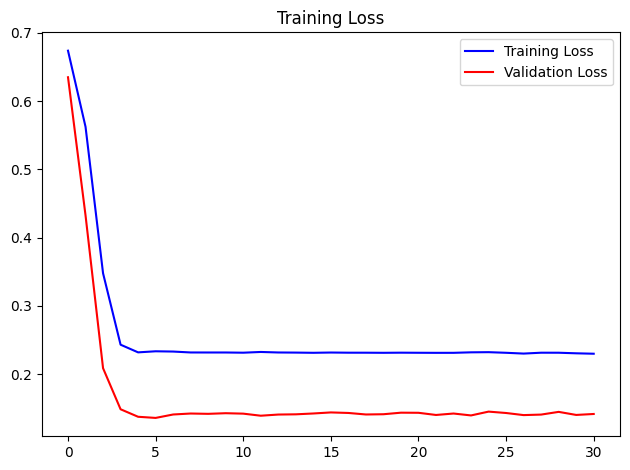

Training loss 0.2298632264137268
Validation loss 0.1358208805322647
2/2 [==============================] - 0s 26ms/step


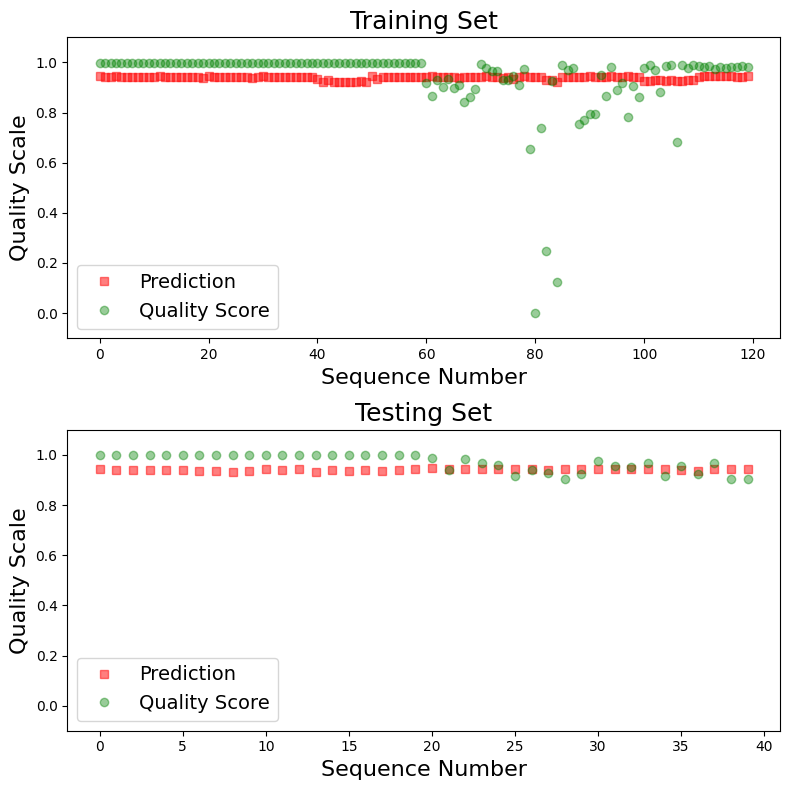

In [253]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))


# Plot the prediction of the model for the training and validation sets
pred_train = model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = model.predict([validx, validx_2, validx_4, validx_8])

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
# plt.savefig('../../Results/SpatioTemporalNN_Vicon_Scores.png', dpi=300)
plt.show()

In [254]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-valid_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.04167982877159118
RMS deviation: 0.04666594681601181
